In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 5.6MB/s 
     |████████████████████████████████| 2.1MB 24.8MB/s 
     |████████████████████████████████| 9.5MB 19.2MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
# Import required packages, libraries and classes for the project
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import datetime as dt
import time
from statsmodels.tsa.arima_model import ARIMAResults
plt.style.use('default')

### Data Preprocessing

In [4]:
# Load the Dataset
df = pd.read_csv("/content/drive/My Drive/stock8030.csv",parse_dates = True,index_col=0)
df.head()

,Open,High,Low,Volume,SMA,EMA,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH,STOCHD,Close
Date,,,,,,,,,,,,,,,
2014-06-15,32.5,32.8,32.4,482290.0,35.033333,35.273907,-2.1,24.189090,-13.793103,-2.032828,34.945,416347.233313,17.073171,18.031482,32.5
2014-06-16,32.5,32.8,32.4,673690.0,35.280952,35.551298,-2.0,24.385914,-14.435696,-2.039900,35.160,573695.586234,17.021277,19.916183,32.6
2014-06-17,32.6,32.9,31.8,604630.0,35.542857,35.846427,-2.4,24.966341,-14.322917,-2.029438,35.415,587012.596435,20.000000,16.806527,32.9
2014-06-18,32.9,34.1,32.9,1160000.0,35.804762,36.141070,-1.9,27.007018,-12.176166,-2.017111,35.675,331923.711053,22.727273,13.558664,33.9
2014-06-19,34.1,34.4,34.1,724030.0,36.028571,36.365177,-2.3,27.434139,-12.113402,-2.073856,35.900,151906.833214,7.692308,15.384615,34.1


In [5]:
# Extracting the features for the SARIMAX model
series = df[["Close",	"MOM",	"RSI",	"ROC",	"MACD",	"BB",	"CHAIKIN",	"STOCH"]]
print(series.shape)
series.tail()

(1460, 8)


,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2020-05-03,16.32,-5.34,26.166536,-26.816143,-0.979347,20.043,1.155662e+06,2.839117
2020-05-04,17.00,-3.66,28.517466,-23.423423,-0.878414,20.357,1.711082e+06,13.564669
2020-05-05,17.54,-2.64,30.596496,-19.541284,-0.796867,20.622,1.772321e+06,14.432990
2020-05-06,18.00,-2.30,32.519916,-14.933837,-0.728218,20.855,2.090245e+06,20.634921
2020-05-07,18.38,-2.10,34.211981,-11.464355,-0.669480,21.045,2.565820e+06,23.204420


In [6]:
# Make actual column contain the next day close value to be predicted 
steps=-1
dataset_with_step= series.copy()
dataset_with_step['Actual']=dataset_with_step['Close'].shift(steps)
dataset_with_step.dropna(inplace=True)
dataset_with_step.tail(3)

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH,Actual
Date,,,,,,,,,
2020-05-04,17.00,-3.66,28.517466,-23.423423,-0.878414,20.357,1.711082e+06,13.564669,17.54
2020-05-05,17.54,-2.64,30.596496,-19.541284,-0.796867,20.622,1.772321e+06,14.432990,18.00
2020-05-06,18.00,-2.30,32.519916,-14.933837,-0.728218,20.855,2.090245e+06,20.634921,18.38


In [7]:
# normalizing input features
from sklearn.preprocessing import StandardScaler
sc_in = StandardScaler()
scaled_input = sc_in.fit_transform(dataset_with_step[["Close",	"MOM",	"RSI",	"ROC",	"MACD",	"BB",	"CHAIKIN",	"STOCH"]])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [8]:
# normalizing output features
sc_out = StandardScaler()
scaler_output = sc_out.fit_transform(dataset_with_step[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [9]:
#Ceeate a dataframe to work with it after scaling 
X.rename(columns={0:'Close', 1:'MOM', 2:'RSI', 3:'ROC', 4:'MACD', 5:'BB', 6:'CHAIKIN',7:"STOCH"}, inplace=True)
X= pd.DataFrame(X)
X.index=dataset_with_step.index
X.tail(2)

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2020-05-05,-0.938370,-0.464017,-1.753898,-1.088484,-0.433430,-0.776812,0.182173,-1.117557
2020-05-06,-0.913264,-0.406389,-1.592451,-0.863732,-0.399617,-0.763902,0.286213,-0.913854


In [10]:
y.rename(columns={0:'Stock Price next day'}, inplace= True)
y.index=dataset_with_step.index
y.tail(2)

,Stock Price next day
Date,
2020-05-05,-0.912492
2020-05-06,-0.891758


In [11]:
# Train Val Test Split
train_start = dt.date(2014,5,15)
train_end = dt.date(2020,3,1)
X_train = X.loc[train_start:train_end]
y_train = y.loc[train_start:train_end]

test_start = dt.date(2020,3,2)
test_end = dt.date(2020,6,14)
X_test = X.loc[test_start:test_end]
y_test = y.loc[test_start:test_end]

print(X_train.shape,X_test.shape)

(1411, 8) (48, 8)


In [12]:
#Find the east parameters and model to fit the data 
from pmdarima.arima import auto_arima
step_wise=auto_arima(y_train, 
                     exogenous= X_train,
                     start_p=1,  start_q=1, 
                     max_p=7,  max_q=7, 
                     d=1, max_d=7,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3362.950, Time=6.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3363.637, Time=0.93 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3361.648, Time=2.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3361.724, Time=5.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3365.360, Time=1.35 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 16.971 seconds


In [13]:
step_wise.summary()
# Show the best parameters for SARIMAX as (0, 1, 0) after a one-step shift for the actual feature

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1411
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1691.680
Date:                Mon, 04 Jan 2021   AIC                          -3365.360
Time:                        18:12:54   BIC                          -3318.098
Sample:                             0   HQIC                         -3347.698
                               - 1411                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Close         -0.3845      0.045     -8.559      0.000      -0.473      -0.296
MOM           -0.0010      0.006     -0.180      0.857      -0.012       0.010
RSI            0.0066      0.022      0.302      0.763      -0.036       0.050
ROC           -0.0424      0.008     -5.304      0.000      -0.058      -0.027
MACD           0.6161      0.010     63.506      0.000       0.597       0.635
BB             0.3816      0.063      6.045      0.000       0.258       0.505
CHAIKIN       -0.0302      0.007     -4.461      0.000      -0.043      -0.017
STOCH          0.0005      0.008      0.060      0.952      -0.016       0.017
sigma2         0.0053   5.47e-05     97.195      0.000       0.005       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            271792.40
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             2.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        70.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

model= SARIMAX(y_train, 
           exog=X_train,
              order=(0,1,0),
              enforce_invertibility=False, enforce_stationarity=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [15]:
results= model.fit()

In [16]:
train_size = len(X_train)
test_size = len(X_test)

In [17]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps),exog=X_test)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [18]:
y_train_inv = sc_out.inverse_transform(y_train)
y_test_inv = sc_out.inverse_transform(y_test)
y_pred_inv = sc_out.inverse_transform(np.array([predictions]).T)

In [19]:
y_train_inv = pd.DataFrame(y_train_inv)
y_train_inv.reset_index(drop=True, inplace=True)
y_train_inv.index = y_train.index
y_train_inv.rename(columns={0	:'Stock Price next day'}, inplace=True)

In [20]:
predictions_df=pd.DataFrame(y_pred_inv)
predictions_df.reset_index(drop=True, inplace=True)
predictions_df.index=X_test.index
predictions_df['Actual'] = y_test_inv
predictions_df.rename(columns={0	:'Pred'}, inplace=True)

In [21]:
train_date = df['2014-05-15' : '2020-03-1'].index
test_date = df['2020-03-2' :].index[:-1]
pred_date = df['2020-03-2' :].index[:-1]

In [22]:
import tensorflow as tf

In [23]:
pred = np.array([predictions]).T

In [24]:
mae = tf.keras.losses.MeanAbsoluteError()
mae = mae(y_test, pred).numpy()

mape = tf.keras.losses.MeanAbsolutePercentageError()
mape = mape(y_test, pred).numpy()

mse = tf.keras.losses.MeanSquaredError()
mse = mse(y_test, pred).numpy()

rmse = sqrt(mse)

In [25]:
print('MSE = {}'.format(round(mse, 5)))
print('RMSE = {}'.format(round(rmse, 5)))
print('MAPE = {}'.format(round(mape, 5)))
print('MAE = {}'.format(round(mae, 5)))

MSE = 0.02985
RMSE = 0.17277
MAPE = 15.9137
MAE = 0.15685


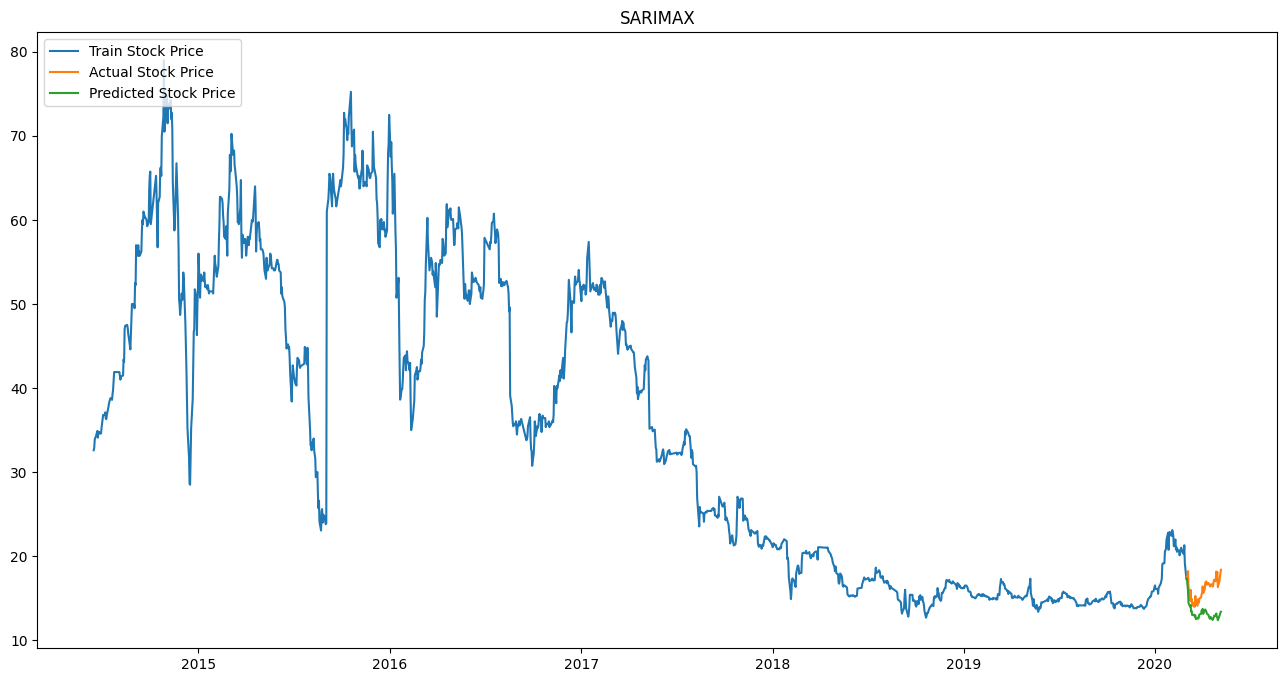

In [26]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

plt.figure(figsize=(16,8))
price_close_train = y_train_inv["Stock Price next day"]
price_close_test = predictions_df['Actual']
plt.plot(train_date, price_close_train, label = "Train Stock Price")
plt.plot(test_date, price_close_test, label = "Actual Stock Price")
plt.plot(pred_date, predictions_df['Pred'], label = "Predicted Stock Price")

plt.title("SARIMAX")
plt.legend(loc='upper left')
#plt.tight_layout()

plt.show()

In [27]:
results.save('model3.pkl')